# Import modules

In [45]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [46]:
# Add at the beginning of your notebook to make imports work
import sys
import os

# Get the absolute path to the project root directory (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to Python's import path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

In [47]:
project_root

'/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon'

In [48]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [49]:
from config.params import FusionParams
from config.initialize_simulation import initialize_state
from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import (
    create_stochastic_avail_price_process, plot_price,
    create_price_with_volatility_strike,
    create_price_with_multiple_volatility_strikes
)

from real_data_fetcher import fetch

from config.psub import psub


# Price Traj Generation

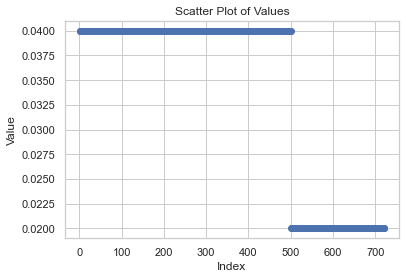

0.02


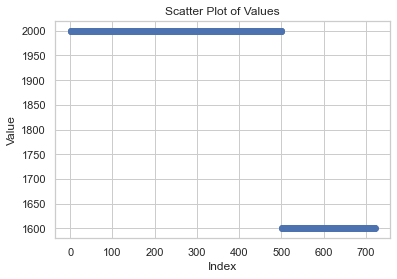

1600.0


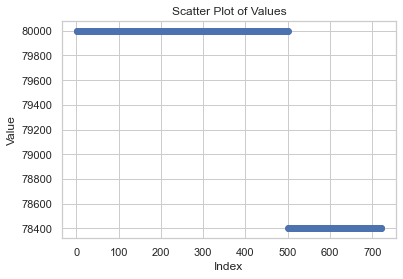

78400.0


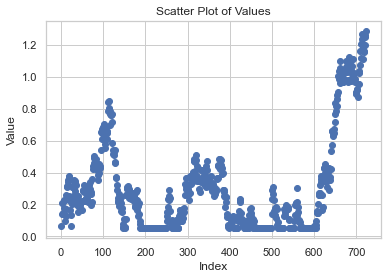

0.05


In [50]:
# types
Run = int
Timestep = int

avl_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0)


# from config.config import (
#     TIMESTEPS,
#     DELTA_TIME,
# )
# avl_price_samples = [0.1] * TIMESTEPS
strike_day = 500
avl_price_samples = create_price_with_volatility_strike(base_price=0.04, strike_timestep=strike_day,pct_change=-0.5)

plot_price(avl_price_samples)
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=1500, target_avg=2500, maximum_avl_price=3000)
eth_price_samples = create_price_with_volatility_strike(base_price=2000, strike_timestep=strike_day,pct_change=-0.2)
plot_price(eth_price_samples)
print(min(eth_price_samples))

btc_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=65000, target_avg=95000, maximum_avl_price=110000)
btc_price_samples = create_price_with_volatility_strike(base_price=80000, strike_timestep=strike_day,pct_change=-0.02)
plot_price(btc_price_samples)
print(min(btc_price_samples))

# please ignore lens price simulation rn
lens_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.3, maximum_avl_price=2, volatility=3.0)
plot_price(lens_price_samples)
print(min(lens_price_samples))


In [51]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(min(avl_price_samples))

# plot_price(eth_price_samples) 
# print(min(eth_price_samples))

# Setup

In [52]:
# intial token prices
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.04


In [53]:
# Fixed parameters: to get initial total fdv
def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
    total_fdv = total_supply * avl_price
    return total_fdv

init_total_fdv = fixed_params(avl_price = AVL_initial_price)



In [54]:
constants = {
    "total_supply": 10_000_000_000,
    "init_total_fdv": init_total_fdv,
    "native_staking_ratio": 0.5,
}

In [55]:
## create maxi agents with initial composition
## but set epsilon numbers (<=1) for cold start
agents = AgentStake.create_maxi_agents(
    target_composition={'AVL': 0, 'ETH': 1, 'BTC': 0},  
    total_tvl=1  # $1M total TVL
)

In [56]:
rewards_result = calculate_reward_allocation(
    constants=constants,
    avl_price=0.1,
    total_tvl=250e6,
    avl_stake_pct=0.15,
    target_avl_yield=0.15,
    target_eth_yield=0.035
)



# Simulation

In [57]:
# system parameters
parameters = FusionParams(
    constants=[constants],  # Wrap in list for multiple runs
    avl_price_samples=[avl_price_samples],  # List of price trajectories
    eth_price_samples=[eth_price_samples],
    btc_price_samples=[btc_price_samples],
    lens_price_samples=[lens_price_samples],
    rewards_result=[rewards_result],  # List of reward results
    agents=[agents],  # List of agent configurations
    btc_activation_day=[180]
).__dict__

params = parameters


In [58]:
# initial conditions

initial_conditions = initialize_state(init_total_fdv, constants, rewards_result, params,0)


In [59]:
# Add validation checks
assert len(parameters['avl_price_process']) == 1, "Should have 1 price process"
assert parameters['avl_price_process'][0](0) == avl_price_samples[0], "Price mismatch"
#assert 'run' in initial_conditions, "Missing run key in initial state"



In [60]:
# run simulation

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=600, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


###########################
timestep 0
[DEBUG] update_token_prices
{'avl_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=1.0, balance=6.999999999999999, price=0.04), 'ETH': AssetAllocation(pct=0.0, balance=0, price=2000), 'BTC': AssetAllocation(pct=0.0, balance=0, price=80000)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0), 'eth_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=0.04), 'ETH': AssetAllocation(pct=1.0, balance=9.999999999999999e-05, price=2000), 'BTC': AssetAllocation(pct=0.0, balance=0, price=80000)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0), 'btc_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=0.04), 'ETH': AssetAllocation(pct=0.0, balance=0, price=2000), 'BTC': AssetAllocation(pct=0.0, balance=0.0, price=80000)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0)}
  AVL Flow: $-16,821.82 (D: $210,410.65, W: $227,232.47)
  ETH Flow: $23,924.16 (D: $51,522.69, W: $27,598.53)

DAY 1 - POOL MANAGER ST

In [61]:
print(df)
df.to_csv('simulation_results.csv', index=False, encoding='utf-8')

      timestep                                             agents  \
0            0  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
1            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
2            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
3            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
...        ...                                                ...   
4796       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4797       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4798       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4799       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4800       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   

                                           pool_manager  \
0     PoolManager(total_budget=30000000.0, pools={'A...   
1     PoolManager(total_budget=30000000.0, pools={'A.

# Visualizations

In [62]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [63]:
fig= visualizations.plot_total_security(
    df
)
pio.show(fig)

In [64]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [65]:
fig = visualizations.plot_yield_pct(
    df
)
pio.show(fig)

In [66]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df,
    assets=['AVL', 'ETH', 'BTC']
)
pio.show(fig)
